# Import

In [72]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.matutils import Sparse2Corpus
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import string
import pandas as pd

import matplotlib.pyplot as plt

pd.options.display.width = 1000
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

# Initialise

In [73]:
nltk.download('stopwords')
nltk.download('punkt')

# Initialize WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gadman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/gadman/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Pre-processing functions


In [74]:
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Tokenize text into words
    tokens = word_tokenize(text)
    # Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    # Lemmatize words
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into text
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

# Prep Data

In [75]:
# stop_words = set(stopwords.words('english'))
df = pd.read_csv('unique_data.csv')
# documents = df['review_text'].apply(lambda x: [word for word in word_tokenize(x) if word.lower() not in stop_words and word not in string.punctuation])
documents = df['review_text'].apply(lambda x: preprocess_text(x))

In [76]:
# Tokenize the documents
tokenized_documents = [doc.split() for doc in documents]

# Create a Gensim Dictionary from the tokenized documents
dictionary = Dictionary(tokenized_documents)

# Filter out tokens that appear in less than 5 documents or more than 50% of documents
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Convert the tokenized documents to a bag-of-words representation
bow_corpus = [dictionary.doc2bow(doc) for doc in tokenized_documents]

# Convert the bag-of-words corpus to a TF-IDF corpus
tfidf_model = TfidfModel(bow_corpus)
tfidf_corpus = tfidf_model[bow_corpus]

# Identify best number of topics

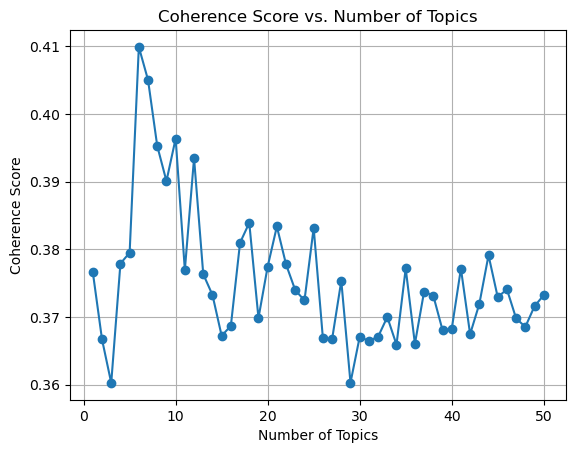

In [83]:
# Define range of numbers of topics to evaluate
num_topics_range = range(1, 51)

# Initialize lists to store coherence scores
coherence_scores = []

# Iterate over different numbers of topics
for num_topics in num_topics_range:
    # Train LSA model
    lsa_model = LsiModel(corpus=tfidf_corpus, id2word=dictionary, num_topics=num_topics)
    
    # Extract top terms for each topic
    top_terms_per_topic = [[term for term, _ in lsa_model.show_topic(topic_id)] for topic_id in range(num_topics)]
    
    # Compute coherence score
    coherence_model = CoherenceModel(topics=top_terms_per_topic, texts=tokenized_documents, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

# Plot coherence score against number of topics
plt.plot(num_topics_range, coherence_scores, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Score vs. Number of Topics')
plt.grid(True)
plt.show()

In [84]:
ideal_k_topics = coherence_scores.index(max(coherence_scores))
best_num_topics = num_topics_range[ideal_k_topics]
print(f'Best Number of Topics: {best_num_topics}')

Best Number of Topics: 6


# Create Latent Semantic Analysis Model

In [85]:
# Train LSA model
num_topics = best_num_topics  # Number of topics
lsa_model = LsiModel(corpus=tfidf_corpus, id2word=dictionary, num_topics=num_topics)

# Extract top terms for each topic
top_terms_per_topic = []
for topic_id in range(num_topics):
    top_terms = [term for term, _ in lsa_model.show_topic(topic_id)]
    top_terms_per_topic.append(top_terms)

# Compute coherence score
coherence_model = CoherenceModel(topics=top_terms_per_topic, texts=tokenized_documents, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f'Coherence Score: {coherence_score}')

Coherence Score: 0.4243365765019799


# Human Evaluation

In [86]:
# Define the number of words to display for each topic
num_words_per_topic = 30  

# Initialize an empty list to store the data for each topic
topic_data = []

# Iterate over each topic
for topic_id in range(num_topics):
    # Get the top words for the current topic
    top_words = [word for word, _ in lsa_model.show_topic(topic_id, topn=num_words_per_topic)]
    print(topic_id, top_words)
    # Add the topic and its corresponding top words to the list
    topic_data.append({'Topic': f'Topic {topic_id + 1}', 'Top Words': ', '.join(top_words)})

# Create a DataFrame from the list of topic data
topic_words_df = pd.DataFrame(topic_data)

# Print the DataFrame
print(topic_words_df)

0 ['good', 'food', 'great', 'place', 'time', '...', 'pizza', 'like', 'get', 'chicken', 'really', 'one', 'always', 'service', 'order', "'ve", 'also', 'go', 'menu', 'love', 'back', 'would', 'restaurant', 'bar', 'burger', 'beer', 'drink', 'nice', 'salad', 'ordered']
1 ['pizza', 'crust', 'slice', 'taco', 'sushi', 'pie', 'topping', 'roll', 'pepperoni', 'cheese', 'thin', 'coffee', 'wing', 'beer', 'breakfast', 'rice', 'salad', 'oven', 'garlic', 'delivery', 'italian', 'egg', 'sauce', 'fish', 'shrimp', 'food', 'tea', 'fried', 'salsa', 'thai']
2 ['coffee', 'roll', 'beer', 'chicken', 'sushi', 'sauce', 'rice', 'store', 'taco', 'soup', 'fried', 'shrimp', 'dish', 'spicy', 'salad', 'shop', 'thai', 'location', 'noodle', 'selection', 'ice', 'starbucks', 'bar', 'pork', 'donut', 'drink', 'ordered', 'lunch', 'cream', 'beef']
3 ['burger', 'beer', 'coffee', 'bar', 'cream', 'ice', 'breakfast', 'taco', 'fry', 'donut', 'roll', 'tea', 'bagel', 'sandwich', 'wing', 'chocolate', 'sushi', 'shop', 'egg', 'drink', 'w

# Word Cloud for Topic

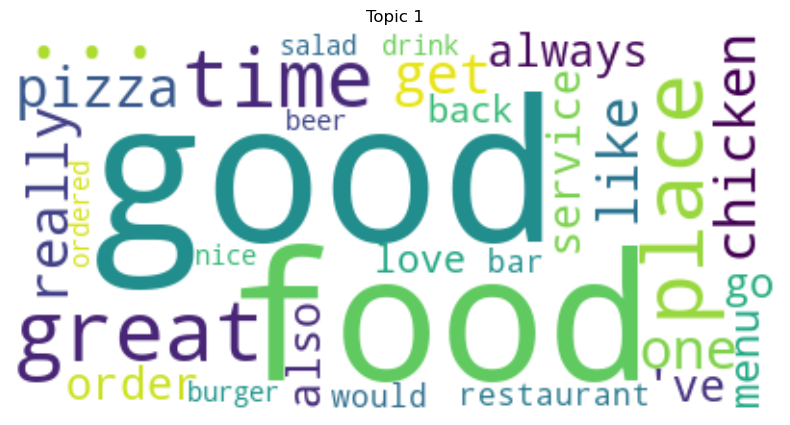

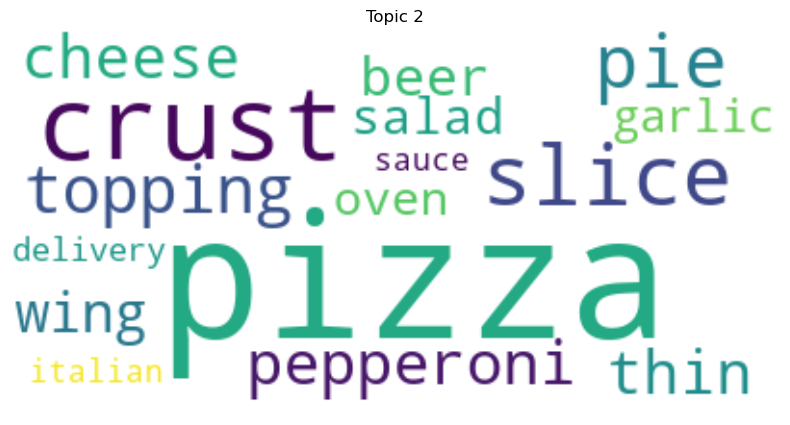

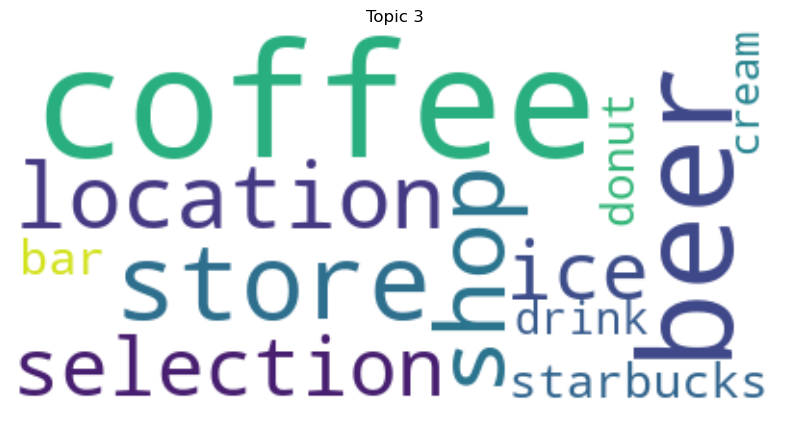

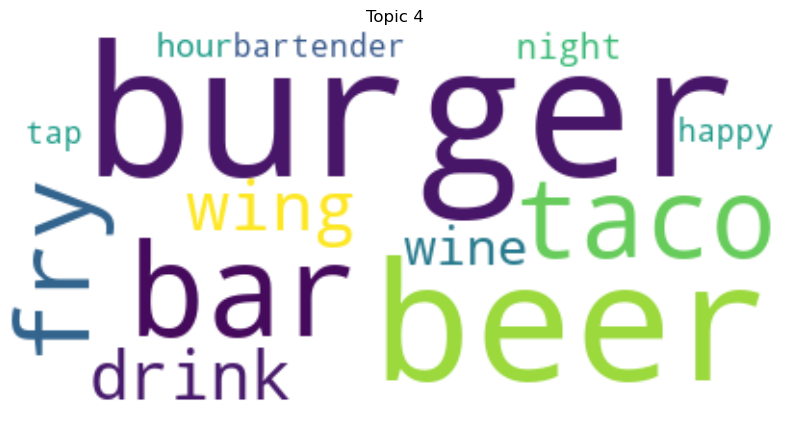

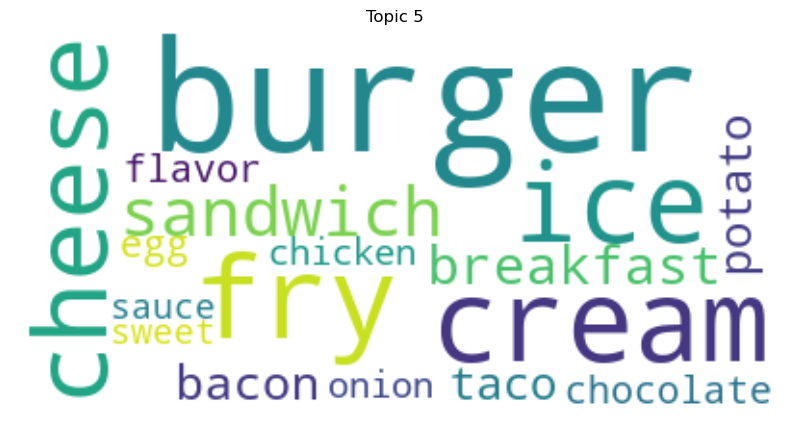

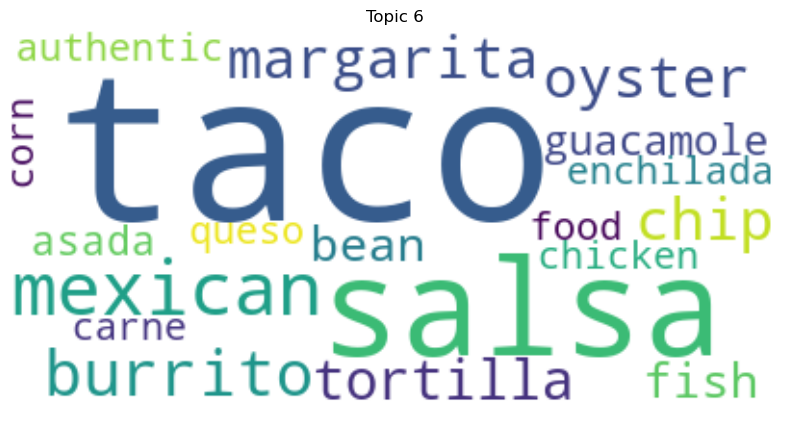

In [89]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Define the number of words to display for each topic
num_words_per_topic = 30  # Adjust as needed

# Create word clouds for each topic
for topic_id in range(num_topics):
    # Get the top words for the current topic
    topic_words = dict(lsa_model.show_topic(topic_id, topn=num_words_per_topic))
    
    # Generate word cloud
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(topic_words)
    
    # Plot word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Topic {topic_id + 1}')
    plt.axis('off')
    plt.show()


# Assigned to topics

In [88]:
# Initialize an empty list to store assigned topics
assigned_topics = []

# Iterate over each document
for bow_doc in tfidf_corpus:
    # Get the document-topic vector from the LSI model
    doc_topics = lsa_model[bow_doc]
    
    # Check if the document-topic vector is not empty
    if doc_topics:
        # Sort the document-topic vector by the second element (topic probability)
        sorted_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)
        
        # Get the topic ID with the highest probability
        most_probable_topic = sorted_topics[0][0]
        
        # Append the index of the most probable topic to the assigned_topics list
        assigned_topics.append(most_probable_topic)
    else:
        # If the document-topic vector is empty, assign a default topic index
        assigned_topics.append(-1)  # or any other suitable default value

# Add the assigned topics to the original DataFrame
df['assigned_topic'] = assigned_topics

df.to_csv('gensimLSA_topic_modelling_results.csv', index=False)